In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
folder = "E:/4D-STEM/Shoucong/Simulations/"
#For thick specimen, the vaccum PACBED reference should be loaded
#PACBED_Ref = np.load(folder + "PACBED.npy")

In [9]:
#load the 4D STEM dataset 
dat4d = np.load(folder+'MoS2 Simu 80kV 30 mrad2.npy')
dat4d = np.reshape(dat4d, (128, 128, 256,256))
pacbed = np.average(dat4d, axis=(0,1))
PACBED_Ref = pacbed

<ipython-input-10-f9f9d049dbd9>:14: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
C:\Users\ningustc\anaconda3\lib\site-packages\mpl_toolkits\axes_grid1\axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar
<ipython-input-10-f9f9d049dbd9>:17: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  gr

Text(0.5, 1.0, 'position averaged CBED')

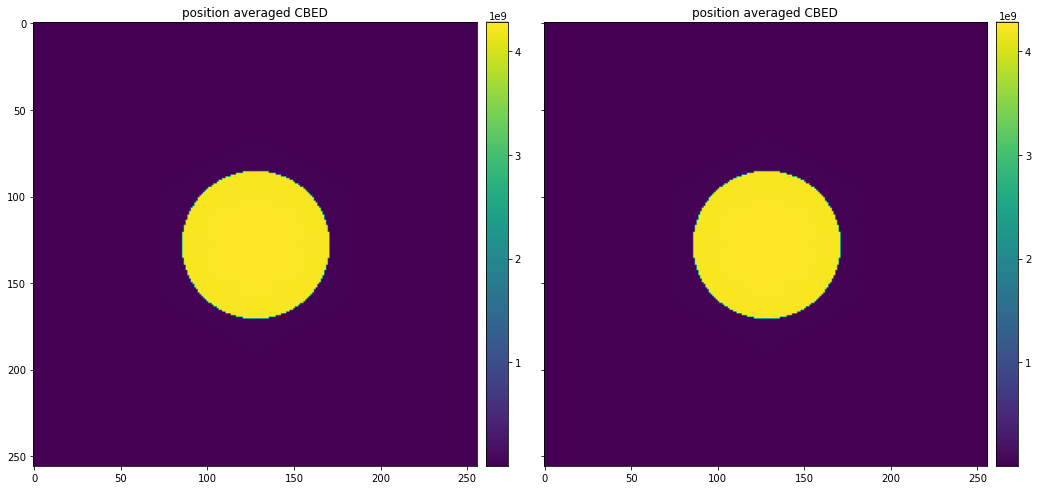

In [10]:
#pacbed[245, 25]=0
#PACBED_Ref[245, 25]=0
#pacbed[120, 132] = pacbed[120, 131]
#PACBED_Ref[120, 132] = PACBED_Ref[120, 131]
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(PACBED_Ref, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("position averaged CBED")

In [11]:
#compute the displacement of PACBED and the reference one using template mathcing/center of mass.
X, Y = np.meshgrid(np.arange(0, pacbed.shape[1]), np.arange(0, pacbed.shape[0]))
x0, y0 =np.average(PACBED_Ref * X), np.average(PACBED_Ref * Y)
x0/=np.average(PACBED_Ref)
y0/=np.average(PACBED_Ref)
x_center, y_center =np.average(pacbed * X), np.average(pacbed * Y)
x_center/=np.average(pacbed)
y_center/=np.average(pacbed)

In [12]:
#Shift the PACBED Reference and use it for STEM image generation
def ShiftDisk(mask,dx,dy):
    expanded = np.zeros((mask.shape[0]*3,mask.shape[1]*3), mask.dtype)
    expanded[mask.shape[0]:2*mask.shape[0],mask.shape[1]:2*mask.shape[1]]=mask
    reci_mask=np.fft.fftshift(np.fft.fft2(expanded))
    x_start = -int(expanded.shape[1]/2)
    y_start = -int(expanded.shape[0]/2)
    x_end = x_start + expanded.shape[1]
    y_end = y_start + expanded.shape[0]
    X, Y = np.meshgrid(np.arange(x_start, x_end),np.arange(y_start,y_end))
    X=X*(1.0/expanded.shape[1]) 
    Y=Y*(1.0/expanded.shape[0])
    reci_mask=reci_mask*np.exp(-2j*np.pi*(dx*X+dy*Y))
    expanded = np.real(np.fft.ifft2(np.fft.ifftshift(reci_mask)))
    return expanded[mask.shape[0]:2*mask.shape[0],mask.shape[1]:2*mask.shape[1]]

<ipython-input-13-0513d5a52e28>:11: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-13-0513d5a52e28>:14: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[1].colorbar(im)


Text(0.5, 1.0, 'position averaged CBED')

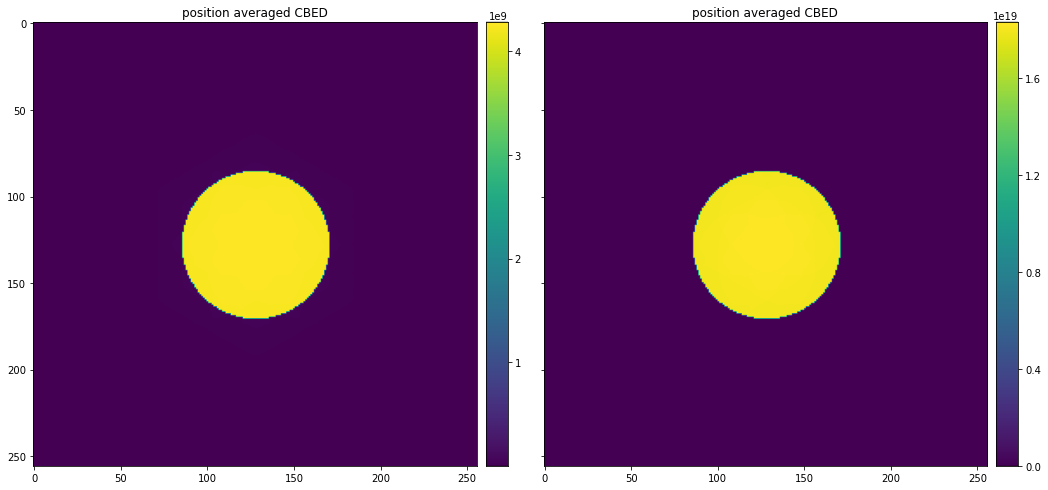

In [13]:
reference = ShiftDisk(PACBED_Ref, x_center- x0, y_center- y0)
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(reference*pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("position averaged CBED")

In [14]:
#generate the STEM images according to the reference PACBED
thresh = np.max(reference)*0.32
BFdisk = pacbed > thresh
grad=np.sqrt(np.sum(np.square(np.abs(np.gradient(reference))), axis =0))
edge = grad > np.max(grad)*0.5
radius = np.average(np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)[edge])
InnerBFdisk = (np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2))<(radius/2)
BFImage=[]
InnerBFImage=[]
for ycan in range(np.shape(dat4d)[0]):
    for xcan in range(np.shape(dat4d)[1]):
        BFImage.append(np.sum(dat4d[ycan,xcan,:,:]*BFdisk))
        InnerBFImage.append(np.sum(dat4d[ycan,xcan,:,:]*InnerBFdisk))
BFImage = np.reshape(np.asarray(BFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
InnerBFImage = np.reshape(np.asarray(InnerBFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
ADFImage = np.sum(dat4d, axis=(2,3))-BFImage
ABFImage = BFImage - InnerBFImage

<ipython-input-15-47a0046db3c2>:10: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-15-47a0046db3c2>:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[1].colorbar(im)
<ipython-input-15-47a0046db3c2>:16: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar impl

Text(0.5, 1.0, 'Annular Dark Field Image')

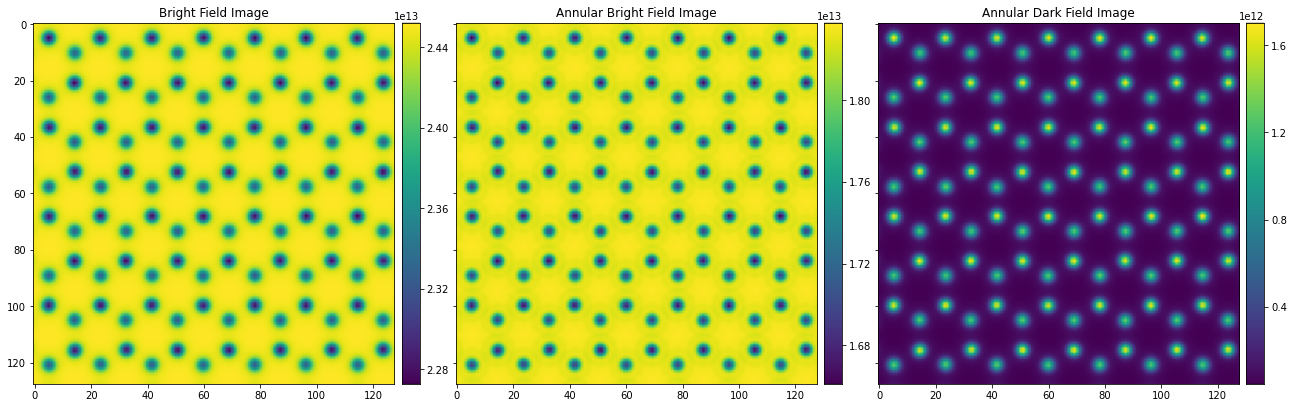

In [15]:
fig =plt.figure(1, figsize=(75, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(BFImage, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Bright Field Image")
im=grid[1].imshow(ABFImage, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Annular Bright Field Image")
im=grid[2].imshow(ADFImage, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Annular Dark Field Image")

In [16]:
#get the electric field components using the center of mass (COM)
xCoM=[]
yCoM=[]
ShiftX = X - x_center
ShiftY = Y - y_center
for ycan in range(np.shape(dat4d)[0]):
    for xcan in range(np.shape(dat4d)[1]):
        masked_cbed = dat4d[ycan,xcan,:,:]*BFdisk
        xCoM.append(np.sum(masked_cbed*ShiftX)/np.sum(masked_cbed))
        yCoM.append(np.sum(masked_cbed*ShiftY)/np.sum(masked_cbed))
xCoM = np.reshape(np.asarray(xCoM), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
yCoM = np.reshape(np.asarray(yCoM), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
EMag = np.sqrt(xCoM ** 2 + yCoM ** 2)

<ipython-input-17-5699294e33fe>:10: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)
<ipython-input-17-5699294e33fe>:13: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[1].colorbar(im)
<ipython-input-17-5699294e33fe>:16: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar impl

Text(0.5, 1.0, 'Magnitude')

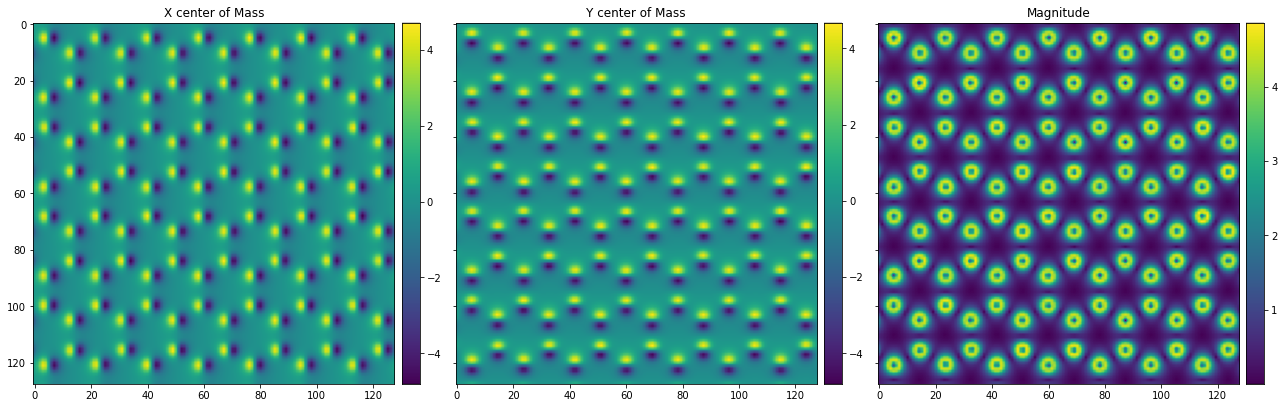

In [17]:
fig =plt.figure(1, figsize=(75, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(xCoM, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("X center of Mass")
im=grid[1].imshow(yCoM, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Y center of Mass")
im=grid[2].imshow(EMag, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Magnitude")

In [18]:
#We need to calibrate the electric field first using the Jmatrix method[Ref. S. Ning et.al].
EX = -xCoM
EY = -yCoM
ADF_binary = ADFImage>(np.max(ADFImage)*0.7)
EXY,EXX=np.gradient(EX);EYY,EYX=np.gradient(EY)
JMatrix =[np.sum(EXX*EXX),np.sum(EYX*EYX), np.sum(EXY*EXY), np.sum(EYY*EYY)]
Weighted_JMatrix =[np.sum(EXX*ADF_binary),np.sum(EYX*ADF_binary), np.sum(EXY*ADF_binary), np.sum(EYY*ADF_binary)]

In [20]:
tan_val = 2*np.sum(EYY*EYX-EXX*EXY)/(JMatrix[1]+JMatrix[2]-JMatrix[0]-JMatrix[3])
angle_val = math.atan(tan_val)
print(angle_val/2)
print(angle_val*90/np.pi)
print(Weighted_JMatrix)
print(JMatrix)

-8.125974939911535e-06
-0.0004655840684860037
[1137.6469628535297, -1.415599454831177, -1.4235449024668487, 1138.3508242629905]
[11547.110001864341, 4296.816750582436, 4224.167395728865, 11613.804983870428]


In [36]:
#The flip appear as shown by the Weight Jmatrix, so the X direction is inverted.
#The rotation angle of x is pi+-0.21941110996882812
#The rotation angle of y is -0.21941110996882812
#Now correct the geometric relationship.
x_rot = angle_val/2 + np.pi  #flip
y_rot = angle_val/2
rEX = EX * np.cos(x_rot) - EY * np.sin(y_rot)
rEY = EX * np.sin(x_rot) + EY * np.cos(y_rot)

<ipython-input-38-f8cdf5326395>:9: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EHSV1[i, j] = np.angle(np.complex(EX[i, j], EY[i, j])) / (2 * np.pi) % 1, 1, EMagNorm1[i, j]
<ipython-input-38-f8cdf5326395>:10: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EHSV2[i, j] = np.angle(np.complex(rEX[i, j], rEY[i, j])) / (2 * np

Text(0.5, 1.0, 'Corrected Charge density')

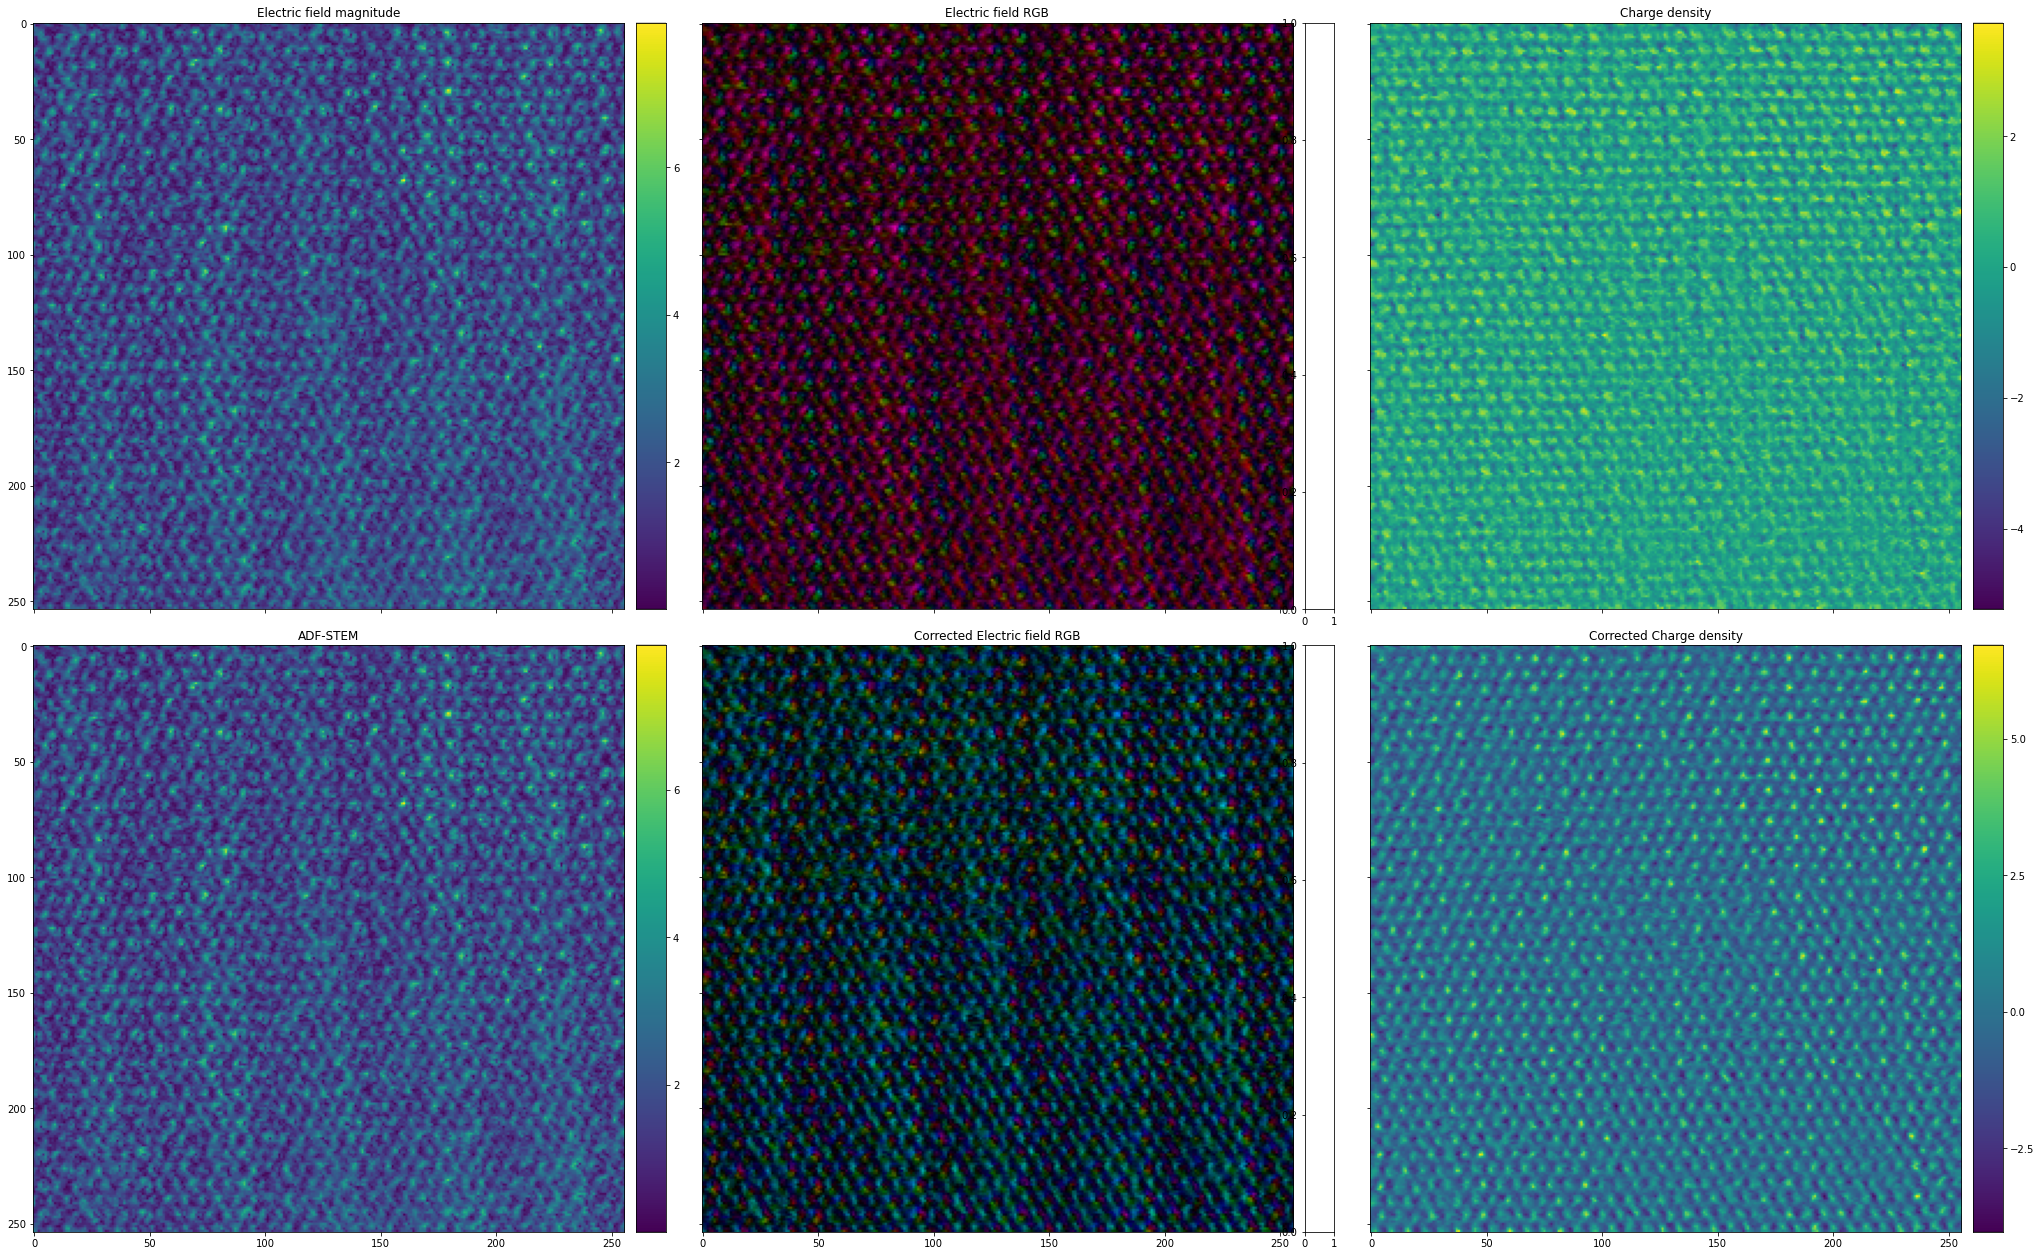

In [38]:
EMagnitude1 = np.sqrt(EX ** 2 + EY ** 2)
EMagnitude2 = np.sqrt(rEX ** 2 + rEY ** 2)
EMagNorm1 = EMagnitude1 / np.amax(EMagnitude1)
EMagNorm2 = EMagnitude2 / np.amax(EMagnitude2)
EHSV1 = np.zeros(EX.shape + (3,), dtype=float)
EHSV2 = np.zeros(EX.shape + (3,), dtype=float)
for i in range(EX.shape[0]):
    for j in range(EX.shape[1]):
        EHSV1[i, j] = np.angle(np.complex(EX[i, j], EY[i, j])) / (2 * np.pi) % 1, 1, EMagNorm1[i, j]
        EHSV2[i, j] = np.angle(np.complex(rEX[i, j], rEY[i, j])) / (2 * np.pi) % 1, 1, EMagNorm2[i, j]
ERGB1=hsv_to_rgb(EHSV1)
ERGB2=hsv_to_rgb(EHSV2)
ChargeDense1 = np.gradient(EX)[1]+np.gradient(EY)[0]
ChargeDense2 = np.gradient(rEX)[1]+np.gradient(rEY)[0]
#Show the charge density and electric field.
fig =plt.figure(1, figsize=(120, 80))
grid=AxesGrid(fig, 236, nrows_ncols=(2,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(EMagnitude1, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Electric field magnitude")
im=grid[1].imshow(ERGB1)
grid[1].set_title("Electric field RGB")
im=grid[2].imshow(ChargeDense1, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Charge density")
im=grid[3].imshow(EMagnitude2, cmap=plt.cm.viridis)
grid.cbar_axes[3].colorbar(im)
grid[3].set_title("ADF-STEM")
im=grid[4].imshow(ERGB2)
grid[4].set_title("Corrected Electric field RGB")
im=grid[5].imshow(ChargeDense2, cmap=plt.cm.viridis)
grid.cbar_axes[5].colorbar(im)
grid[5].set_title("Corrected Charge density")

In [40]:
#save the electric field for further processing.
np.save(folder + "EX.npy", rEX)
np.save(folder + "EY.npy", rEY)
np.save(folder + "ADF.npy", ADFImage)